In [2]:
import pandas as pd
import datetime
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn import preprocessing

import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('../../sample_data_2017_M4_v3.csv', 
                 dtype= {'FormationYr':'object'},
                 low_memory=False)

In [5]:
df.shape

(41987, 51)

In [6]:
df.columns

Index(['ActivityOrMissionDesc', 'BooksInCareOfDetail/USAddress/ZIPCode',
       'CYSalariesCompEmpBnftPaidAmt', 'CYTotalExpensesAmt',
       'CYTotalProfFndrsngExpnsAmt', 'CYTotalRevenueAmt', 'Desc', 'EIN',
       'EmployeeCnt', 'Form990TotalAssetsGrp/EOYAmt', 'FormType',
       'FormationYr', 'GovernmentGrantsAmt', 'GrossReceiptsAmt', 'MissionDesc',
       'NetAssetsOrFundBalancesEOYAmt', 'NetAssetsOrFundBalancesGrp/EOYAmt',
       'NoListedPersonsCompensatedInd', 'OrganizationName',
       'OtherSalariesAndWagesGrp/TotalAmt', 'PYSalariesCompEmpBnftPaidAmt',
       'PYTotalExpensesAmt', 'PYTotalProfFndrsngExpnsAmt', 'PYTotalRevenueAmt',
       'PrimaryExemptPurposeTxt', 'PrincipalOfficerNm',
       'RelatedOrganizationsAmt', 'RevenueAmt', 'ScheduleBRequiredInd',
       'TaxExemptBondsInd', 'TaxPeriod',
       'TotLiabNetAssetsFundBalanceGrp/BOYAmt',
       'TotLiabNetAssetsFundBalanceGrp/EOYAmt', 'TotalAssetsGrp/BOYAmt',
       'TotalAssetsGrp/EOYAmt', 'TotalContributionsAmt', 'TotalE

In [7]:
df = df[df['FormType'] == '990']

In [8]:
df = df.drop(['ActivityOrMissionDesc'
              , 'BooksInCareOfDetail/USAddress/ZIPCode'
              , 'PrincipalOfficerNm'
              , 'Desc'
              , 'MissionDesc'
              , 'PrimaryExemptPurposeTxt'
              , 'OrganizationName'
              , 'URL'
              , 'WebsiteAddressTxt'
              , '_id'
              , 'FormType'
              , 'TaxExemptBondsInd'
              , 'NoListedPersonsCompensatedInd'
              , 'TaxPeriod'
             ], axis =1)

In [9]:
# transform scheduleB required boolean column to binary
df['ScheduleBRequiredInd'] = df['ScheduleBRequiredInd'].fillna(0)
df['ScheduleBRequiredInd'] = df['ScheduleBRequiredInd'].replace('false', 0)
df['ScheduleBRequiredInd'] = df['ScheduleBRequiredInd'].replace('true', 1)
df['ScheduleBRequiredInd'] = df['ScheduleBRequiredInd'].replace('0', 0)
df['ScheduleBRequiredInd'] = df['ScheduleBRequiredInd'].replace('1', 1)
df['ScheduleBRequiredInd'] = df['ScheduleBRequiredInd'].astype('int64')

In [10]:
# transform formation year into age calcualtion
df['FormationYr'] = df['FormationYr'].fillna(0)
df['FormationYr'] = df['FormationYr'].astype('int64')
now = datetime.datetime.now()
# age is current year minus formation year, else 0
df['FilerAge'] = df['FormationYr'].apply(lambda x: now.year-x if x != 0 else 0)

In [11]:
df = df.fillna(0)

In [12]:
def replace_infinity(result):
    result = result.fillna(0)
    result = result.replace(np.inf, 1.0)
    result = result.replace(-np.inf, 0.0)
    return result

In [13]:
# df.replace([np.inf, -np.inf], np.nan)
def calculatePercentChange(series1, series2):
    result = (series1-series2)/series1
    return replace_infinity(result)

In [14]:
# TotalContributionsAmt divided by RevenueAmt
df['TotalContribRatio'] = df['TotalContributionsAmt']/df['RevenueAmt']
df['TotalContribRatio'] = replace_infinity(df['TotalContribRatio'])

In [15]:
# ProgramServicesAmt divided by TotalAmt
df['ProgramServicesRatio'] = df['TotalFunctionalExpensesGrp/ProgramServicesAmt']/df['TotalFunctionalExpensesGrp/TotalAmt']
df['ProgramServicesRatio'] = replace_infinity(df['ProgramServicesRatio'])

In [16]:
# ProgramServicesAmt divided by TotalAmt
df['ManagementExpRatio'] = df['TotalFunctionalExpensesGrp/ManagementAndGeneralAmt']/df['TotalFunctionalExpensesGrp/TotalAmt']
df['ManagementExpRatio'] = replace_infinity(df['ManagementExpRatio'])


In [17]:
# ProgramServicesAmt divided by TotalAmt
df['FundraisingRatio'] = df['TotalFunctionalExpensesGrp/FundraisingAmt']/df['TotalFunctionalExpensesGrp/TotalAmt']
df['FundraisingRatio'] = replace_infinity(df['FundraisingRatio'])


In [18]:
# % Change of Assets over the year
df['PercentTotalAsstChng'] = calculatePercentChange(df['TotalAssetsGrp/BOYAmt'], df['TotalAssetsGrp/EOYAmt'])
df['PercentFundBalChng'] = calculatePercentChange(df['TotLiabNetAssetsFundBalanceGrp/BOYAmt'], df['TotLiabNetAssetsFundBalanceGrp/EOYAmt'])
df['PercentTotalLiabChng'] = calculatePercentChange(df['TotalLiabilitiesGrp/BOYAmt'], df['TotalLiabilitiesGrp/EOYAmt'])

In [19]:
# Drop Columns!
df = df.drop(columns=['FormationYr',
                      'TotalContributionsAmt',
                      'TotalFunctionalExpensesGrp/ProgramServicesAmt',
                      'TotalFunctionalExpensesGrp/ManagementAndGeneralAmt',
                      'TotalFunctionalExpensesGrp/FundraisingAmt',
                      'TotalAssetsGrp/BOYAmt',
                      'TotLiabNetAssetsFundBalanceGrp/BOYAmt',
                      'TotalLiabilitiesGrp/BOYAmt'
                     ])

In [20]:
(df.isna().sum()/df.shape[0])*100

CYSalariesCompEmpBnftPaidAmt             0.0
CYTotalExpensesAmt                       0.0
CYTotalProfFndrsngExpnsAmt               0.0
CYTotalRevenueAmt                        0.0
EIN                                      0.0
EmployeeCnt                              0.0
Form990TotalAssetsGrp/EOYAmt             0.0
GovernmentGrantsAmt                      0.0
GrossReceiptsAmt                         0.0
NetAssetsOrFundBalancesEOYAmt            0.0
NetAssetsOrFundBalancesGrp/EOYAmt        0.0
OtherSalariesAndWagesGrp/TotalAmt        0.0
PYSalariesCompEmpBnftPaidAmt             0.0
PYTotalExpensesAmt                       0.0
PYTotalProfFndrsngExpnsAmt               0.0
PYTotalRevenueAmt                        0.0
RelatedOrganizationsAmt                  0.0
RevenueAmt                               0.0
ScheduleBRequiredInd                     0.0
TotLiabNetAssetsFundBalanceGrp/EOYAmt    0.0
TotalAssetsGrp/EOYAmt                    0.0
TotalEmployeeCnt                         0.0
TotalFunct

In [21]:
(df.isin([np.inf, -np.inf]).sum()/df.shape[0])*100

CYSalariesCompEmpBnftPaidAmt             0.0
CYTotalExpensesAmt                       0.0
CYTotalProfFndrsngExpnsAmt               0.0
CYTotalRevenueAmt                        0.0
EIN                                      0.0
EmployeeCnt                              0.0
Form990TotalAssetsGrp/EOYAmt             0.0
GovernmentGrantsAmt                      0.0
GrossReceiptsAmt                         0.0
NetAssetsOrFundBalancesEOYAmt            0.0
NetAssetsOrFundBalancesGrp/EOYAmt        0.0
OtherSalariesAndWagesGrp/TotalAmt        0.0
PYSalariesCompEmpBnftPaidAmt             0.0
PYTotalExpensesAmt                       0.0
PYTotalProfFndrsngExpnsAmt               0.0
PYTotalRevenueAmt                        0.0
RelatedOrganizationsAmt                  0.0
RevenueAmt                               0.0
ScheduleBRequiredInd                     0.0
TotLiabNetAssetsFundBalanceGrp/EOYAmt    0.0
TotalAssetsGrp/EOYAmt                    0.0
TotalEmployeeCnt                         0.0
TotalFunct

Notes: 

Related organizations are organizations that stand in a parent/subsidiary relationship, brother/sister relationship, sponsoring organization of or contributing employer to a VEBA, or supporting/supported organization relationship. Supporting and supported organizations are defined in section 509(a)(3) and 509(f)(3). The first two relationships depends on a definition of control set forth in the Form 990 instructions glossary and Schedule R instructions. The definition of control depends on whether the organization has owners or persons with beneficial interests.

Ideas:
calculate change from PY to CY for total expenses, total professional fundraising, and total revenue.
TotalAssetsGrp/EOYAmt seems to be included in the CYTotalProfFndrsngExpnsAmt

In [22]:
cols = df.columns
print(len(cols))
set_cols = set(cols)
cols_not_scale = ['EIN', 
                  'FilerAge',
                  'TotalContribRatio',
                  'FundraisingRatio',
                  'ManagementExpRatio',
                  'PercentFundBalChng',
                  'PercentTotalAsstChng',
                  'PercentTotalLiabChng'
                 ]

for col in cols_not_scale:
    set_cols.remove(col)

37


In [23]:
df = df.fillna(0)
scaler = preprocessing.MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler()

In [24]:
def scaleColumns(df, cols_to_scale):
    for col in cols_to_scale:
        df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df

In [25]:
df = scaleColumns(df, list(set_cols))

In [26]:
len(df.columns)

37

In [27]:
#df = pd.DataFrame(preprocessing.scale(df))
df.columns = cols

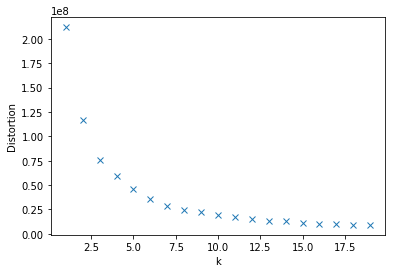

In [28]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init = 'k-means++', random_state = 0).fit(df)
    distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'x')
plt.xlabel('k')
plt.ylabel('Distortion')
# plt.title('num_topics = ' + str(num_topics))
plt.show()

In [29]:
k10 = KMeans(n_clusters=10, init = 'k-means++', random_state = 0).fit(df)

In [31]:
df['labels'] = k10.labels_
df.groupby(['labels']).count()['EIN']

labels
0    1834
1    4251
2    1719
3    1704
4    2983
5    1154
6    1710
7    2681
8    1074
9     976
Name: EIN, dtype: int64

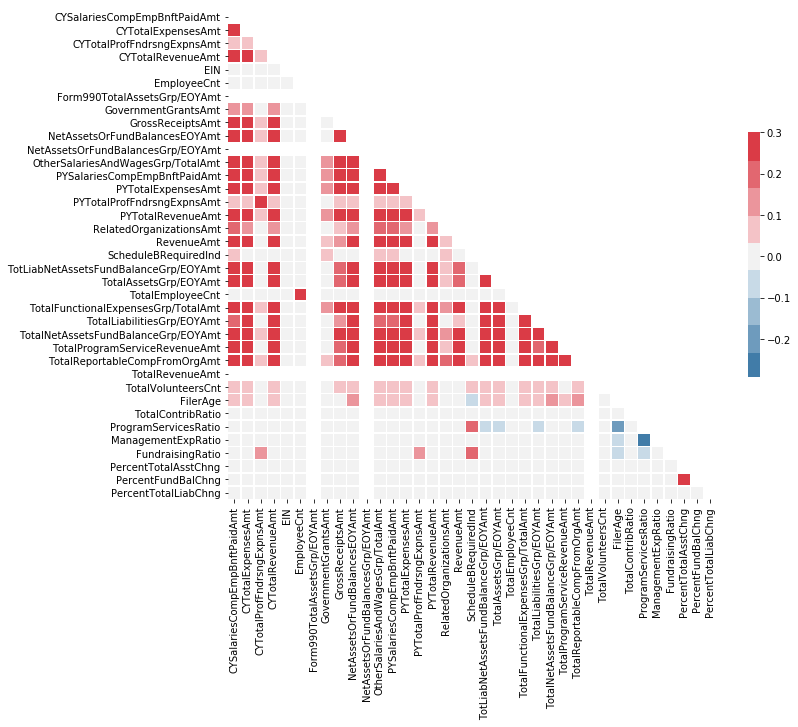

In [29]:
corr = df[cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n=9)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Correlation matrix shows that certain attributes are highly correlated. 

In [30]:
from sklearn.decomposition import PCA 

In [36]:
pca = PCA(n_components=37)
pca.fit(df)
df_pca = pca.transform(df)

df_pca = pd.DataFrame(df_pca)
df_pca['labels'] = df['labels']

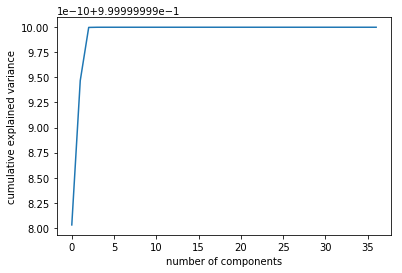

In [37]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

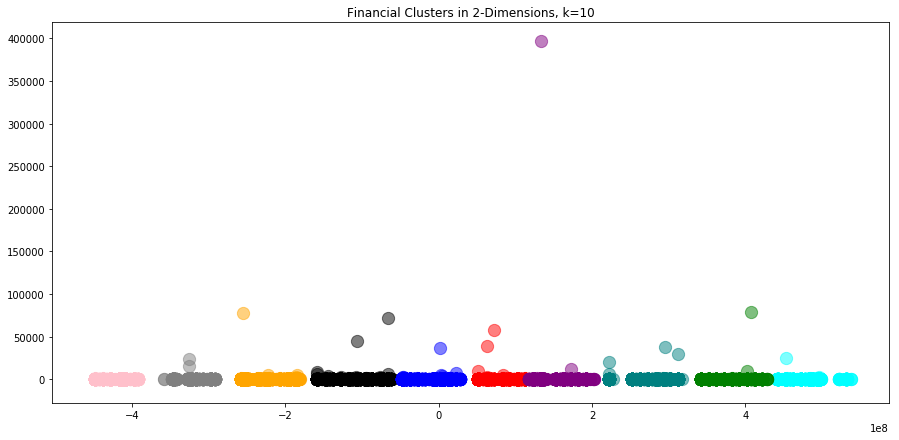

In [32]:
plt.figure(figsize=(15,7))
colors = ['cyan', 'orange', 'red', 'teal', 'black', 'pink', 'purple', 'blue', 'grey', 'green']
for label in range(10):
    df_sample = df_pca[df_pca['labels'] == label]
    x = plt.scatter(df_sample[0], df_sample[1], c = colors[label], alpha = .5, s = 150)
#     plt.legend([x], colors[label])
#     legend = plt.legend(handles=[x])
#     ax = plt.gca().add_artist(legend)
plt.title("Financial Clusters in 2-Dimensions, k=10")
plt.show()

## x-axis appears to be correlated with income (Revenue and Gross Receipts)
## y-axis Net Assets/Revenue(?)

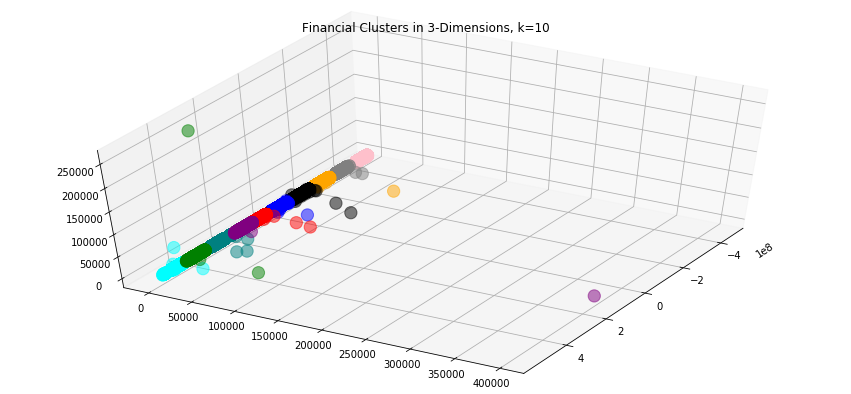

In [33]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='3d')

colors = ['cyan', 'orange', 'red', 'teal', 'black', 'pink', 'purple', 'blue', 'grey', 'green']
for label in range(10):
    df_sample = df_pca[df_pca['labels'] == label]
    x = ax.scatter(df_sample[0], df_sample[1], df_sample[2], c = colors[label], alpha = .5, s = 150)

plt.title("Financial Clusters in 3-Dimensions, k=10")
ax.view_init(50, 30)
plt.show()